In [2]:
# Define dataset path
dataset_path = "/kaggle/input/dataset/inaturalist_12K"

In [3]:
import wandb
wandb.login(key="5fb34431b405eb21dc0f263e5b3cf2c15fdc7471")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma24m004 (ma24m004-iit-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import wandb
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
# Define dataset path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "/kaggle/input/dataset/inaturalist_12K"

def get_dataloaders(dataset_path, augment, batch_size=32):
    # Define transforms
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]) if augment else transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    full_dataset = ImageFolder(root=f"{dataset_path}/train", transform=transform)

    # ✅ Class-balanced 80/20 split
    
    targets = np.array(full_dataset.targets)
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, val_idx in strat_split.split(np.zeros(len(targets)), targets):
        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader

train_loader, val_loader = get_dataloaders(dataset_path, augment=True, batch_size=32)


In [5]:


import torch
import torch.nn as nn

class CNN_Model(nn.Module):
    def __init__(self, 
                 filter_sizes,              # list of conv filters
                 dense_neurons,             # neurons in dense layer
                 activation="relu",         # activation function
                 dropout=0.0,               # dropout rate
                 batch_norm=False,          # whether to use BatchNorm
                 input_shape=(3, 224, 224), # image shape
                 num_classes=10):           # number of output classes
        super(CNN_Model, self).__init__()

        # Activation function class (module, not functional)
        act_layer = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "silu": nn.SiLU,
            "mish": nn.Mish
        }[activation.lower()]
        
        in_channels = input_shape[0]
        layers = []

        # Convolution blocks
        for i, out_channels in enumerate(filter_sizes):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))  # padding=1 to preserve size
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(act_layer())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # downsample by 2
            if dropout > 0:
                layers.append(nn.Dropout2d(dropout))
            in_channels = out_channels

        self.conv_blocks = nn.Sequential(*layers)

        # Automatically infer flatten size
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            flatten_dim = self.conv_blocks(dummy).view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(flatten_dim, dense_neurons),
            act_layer(),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(dense_neurons, num_classes)
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


In [6]:
# ✅ Initialize WandB (resumes existing run if needed)
wandb.init(project="Assignment_2_CNN", resume=True)
def train_cnn_model(model, train_loader, val_loader, config, device):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )

    best_val_acc = 0.0

    for epoch in range(config["epochs"]):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        val_loss /= len(val_loader)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

        # Logging to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    wandb.run.summary["best_val_accuracy"] = best_val_acc
    return model
wandb.finish()

In [6]:

# sweep_config = {
#     "method": "bayes",
#     "metric": {"name": "val_accuracy", "goal": "maximize"},
#     "parameters": {
#         "epochs": {"values": [10,15,20]},
#         "filter_sizes": {
#             "values": [
#                 [16, 32, 32, 256, 512],
#                 [128, 128, 128, 128, 256],
#                 [256, 128, 64, 32, 32],
#                 [32, 64, 128, 128, 256],
#             ]
#         },
#         "dense_neurons": {"values": [128, 256, 512]},
#         "activation": {"values": ["gelu","relu", "silu", "mish"]},
#         "learning_rate": {"values": [1e-3, 1e-4]},
#         "optimizer": {"values": ["adam"]},
#         "dropout": {"values": [0.2, 0.3]},
#         "data_augmentation": {"values": [True, False]},
#         "batch_norm": {"values": [True, False]},
#         "weight_decay": {"values": [0, 0.0005]},
#     }
# }


In [10]:

def train_wandb():
    with wandb.init():
        config = wandb.config

        # ✅ Load dataset
        dataset_path = "/kaggle/input/dataset/inaturalist_12K"
        train_loader, val_loader = get_dataloaders(
            dataset_path=dataset_path,
            augment=config.data_augmentation,
            batch_size=getattr(config, "batch_size", 32)
        )

        # ✅ Build model from config
        model = CNN_Model(
            filter_sizes=config.filter_sizes,
     
            
            dense_neurons=config.dense_neurons,
            activation=config.activation,
            dropout=config.dropout,
            batch_norm=config.batch_norm,
            input_shape=(3, 224, 224),
            num_classes=10  
        ).to(device)

        # ✅ Optional: log model internals
        wandb.watch(model, log="all", log_freq=100)

        # ✅ Train with early stopping
        train_cnn_model(model, train_loader, val_loader, config, device)

# Launch sweep
sweep_id = wandb.sweep(sweep_config, project="Assignment_2_CNN")
wandb.agent(sweep_id, function=train_wandb, count=50)


Create sweep with ID: hadf6gre
Sweep URL: https://wandb.ai/ma24m004-iit-madras/Assignment_2_CNN/sweeps/hadf6gre


wandb: Agent Starting Run: cbptmdhx with config:
wandb: 	activation: gelu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 10.00% | Val Acc: 10.20%
Epoch 2 | Train Acc: 10.50% | Val Acc: 11.80%
Epoch 3 | Train Acc: 10.89% | Val Acc: 12.35%
Epoch 4 | Train Acc: 11.89% | Val Acc: 13.70%
Epoch 5 | Train Acc: 12.31% | Val Acc: 13.40%
Epoch 6 | Train Acc: 11.81% | Val Acc: 13.00%
Epoch 7 | Train Acc: 12.28% | Val Acc: 13.45%
Epoch 8 | Train Acc: 12.33% | Val Acc: 13.90%
Epoch 9 | Train Acc: 12.39% | Val Acc: 13.25%
Epoch 10 | Train Acc: 12.05% | Val Acc: 13.50%
Epoch 11 | Train Acc: 12.88% | Val Acc: 13.45%
Epoch 12 | Train Acc: 12.53% | Val Acc: 13.95%
Epoch 13 | Train Acc: 12.90% | Val Acc: 15.00%
Epoch 14 | Train Acc: 12.85% | Val Acc: 14.35%
Epoch 15 | Train Acc: 12.85% | Val Acc: 13.45%
Epoch 16 | Train Acc: 12.68% | Val Acc: 13.25%
Epoch 17 | Train Acc: 12.95% | Val Acc: 14.05%
Epoch 18 | Train Acc: 13.11% | Val Acc: 13.95%
Epoch 19 | Train Acc: 13.21% | Val Acc: 15.00%
Epoch 20 | Train Acc: 13.48% | Val Acc: 14.80%


wandb: Agent Starting Run: k5fvyss1 with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 14.68% | Val Acc: 16.45%
Epoch 2 | Train Acc: 17.63% | Val Acc: 21.05%
Epoch 3 | Train Acc: 20.39% | Val Acc: 25.30%
Epoch 4 | Train Acc: 21.29% | Val Acc: 26.35%
Epoch 5 | Train Acc: 21.40% | Val Acc: 27.30%
Epoch 6 | Train Acc: 22.70% | Val Acc: 25.95%
Epoch 7 | Train Acc: 22.52% | Val Acc: 28.10%
Epoch 8 | Train Acc: 23.57% | Val Acc: 28.90%
Epoch 9 | Train Acc: 23.99% | Val Acc: 30.15%
Epoch 10 | Train Acc: 25.05% | Val Acc: 27.20%
Epoch 11 | Train Acc: 24.84% | Val Acc: 29.00%
Epoch 12 | Train Acc: 25.05% | Val Acc: 30.40%
Epoch 13 | Train Acc: 25.88% | Val Acc: 30.75%
Epoch 14 | Train Acc: 26.05% | Val Acc: 30.15%
Epoch 15 | Train Acc: 25.92% | Val Acc: 31.00%
Epoch 16 | Train Acc: 26.17% | Val Acc: 30.70%
Epoch 17 | Train Acc: 26.80% | Val Acc: 33.15%
Epoch 18 | Train Acc: 27.22% | Val Acc: 32.50%
Epoch 19 | Train Acc: 27.28% | Val Acc: 32.00%
Epoch 20 | Train Acc: 28.32% | Val Acc: 32.60%


wandb: Agent Starting Run: a4s8axd4 with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_sizes: [128, 128, 128, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 15.19% | Val Acc: 14.35%
Epoch 2 | Train Acc: 10.33% | Val Acc: 10.00%
Epoch 3 | Train Acc: 9.89% | Val Acc: 10.00%
Epoch 4 | Train Acc: 9.84% | Val Acc: 10.00%
Epoch 5 | Train Acc: 9.91% | Val Acc: 10.00%
Epoch 6 | Train Acc: 9.04% | Val Acc: 10.00%
Epoch 7 | Train Acc: 9.03% | Val Acc: 10.00%
Epoch 8 | Train Acc: 9.15% | Val Acc: 10.00%
Epoch 9 | Train Acc: 9.24% | Val Acc: 10.00%
Epoch 10 | Train Acc: 9.51% | Val Acc: 10.00%


wandb: Agent Starting Run: 3l3092or with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_sizes: [128, 128, 128, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 12.51% | Val Acc: 15.75%
Epoch 2 | Train Acc: 14.18% | Val Acc: 14.45%
Epoch 3 | Train Acc: 14.30% | Val Acc: 14.65%
Epoch 4 | Train Acc: 14.70% | Val Acc: 15.75%
Epoch 5 | Train Acc: 15.00% | Val Acc: 14.50%
Epoch 6 | Train Acc: 14.96% | Val Acc: 16.20%
Epoch 7 | Train Acc: 15.30% | Val Acc: 17.05%
Epoch 8 | Train Acc: 15.40% | Val Acc: 17.05%
Epoch 9 | Train Acc: 15.74% | Val Acc: 16.10%
Epoch 10 | Train Acc: 15.89% | Val Acc: 16.40%
Epoch 11 | Train Acc: 16.01% | Val Acc: 16.40%
Epoch 12 | Train Acc: 16.48% | Val Acc: 16.60%
Epoch 13 | Train Acc: 15.95% | Val Acc: 16.20%
Epoch 14 | Train Acc: 15.84% | Val Acc: 17.50%
Epoch 15 | Train Acc: 15.64% | Val Acc: 16.50%
Epoch 16 | Train Acc: 15.89% | Val Acc: 15.75%
Epoch 17 | Train Acc: 16.41% | Val Acc: 16.60%
Epoch 18 | Train Acc: 15.69% | Val Acc: 16.00%
Epoch 19 | Train Acc: 16.18% | Val Acc: 16.70%
Epoch 20 | Train Acc: 16.43% | Val Acc: 17.25%


wandb: Agent Starting Run: xn9vpovg with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_sizes: [256, 128, 64, 32, 32]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 18.26% | Val Acc: 22.65%
Epoch 2 | Train Acc: 23.94% | Val Acc: 29.70%
Epoch 3 | Train Acc: 26.54% | Val Acc: 30.80%
Epoch 4 | Train Acc: 28.83% | Val Acc: 31.85%
Epoch 5 | Train Acc: 29.72% | Val Acc: 32.20%
Epoch 6 | Train Acc: 30.80% | Val Acc: 33.60%
Epoch 7 | Train Acc: 31.33% | Val Acc: 34.75%
Epoch 8 | Train Acc: 31.99% | Val Acc: 34.75%
Epoch 9 | Train Acc: 32.67% | Val Acc: 35.25%
Epoch 10 | Train Acc: 33.07% | Val Acc: 35.80%
Epoch 11 | Train Acc: 33.82% | Val Acc: 35.50%
Epoch 12 | Train Acc: 33.95% | Val Acc: 36.15%
Epoch 13 | Train Acc: 35.40% | Val Acc: 37.00%
Epoch 14 | Train Acc: 35.72% | Val Acc: 37.10%
Epoch 15 | Train Acc: 36.30% | Val Acc: 38.35%
Epoch 16 | Train Acc: 37.28% | Val Acc: 36.95%
Epoch 17 | Train Acc: 36.89% | Val Acc: 37.35%
Epoch 18 | Train Acc: 37.94% | Val Acc: 38.80%
Epoch 19 | Train Acc: 39.00% | Val Acc: 38.15%
Epoch 20 | Train Acc: 39.39% | Val Acc: 37.95%


wandb: Agent Starting Run: oyx1pu11 with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [256, 128, 64, 32, 32]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 14.28% | Val Acc: 17.05%
Epoch 2 | Train Acc: 19.20% | Val Acc: 21.10%
Epoch 3 | Train Acc: 20.32% | Val Acc: 22.70%
Epoch 4 | Train Acc: 21.89% | Val Acc: 23.50%
Epoch 5 | Train Acc: 22.73% | Val Acc: 24.65%
Epoch 6 | Train Acc: 23.83% | Val Acc: 25.65%
Epoch 7 | Train Acc: 23.85% | Val Acc: 26.50%
Epoch 8 | Train Acc: 24.37% | Val Acc: 27.40%
Epoch 9 | Train Acc: 24.70% | Val Acc: 27.10%
Epoch 10 | Train Acc: 25.10% | Val Acc: 27.85%
Epoch 11 | Train Acc: 24.95% | Val Acc: 27.35%
Epoch 12 | Train Acc: 25.64% | Val Acc: 27.60%
Epoch 13 | Train Acc: 26.04% | Val Acc: 27.75%
Epoch 14 | Train Acc: 25.75% | Val Acc: 27.05%
Epoch 15 | Train Acc: 26.38% | Val Acc: 26.90%
Epoch 16 | Train Acc: 26.54% | Val Acc: 27.45%
Epoch 17 | Train Acc: 27.17% | Val Acc: 27.30%
Epoch 18 | Train Acc: 27.15% | Val Acc: 27.45%
Epoch 19 | Train Acc: 26.87% | Val Acc: 26.95%
Epoch 20 | Train Acc: 26.44% | Val Acc: 27.00%


wandb: Agent Starting Run: krj0mxwo with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_sizes: [256, 128, 64, 32, 32]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 16.13% | Val Acc: 22.80%
Epoch 2 | Train Acc: 23.59% | Val Acc: 26.25%
Epoch 3 | Train Acc: 25.77% | Val Acc: 27.40%
Epoch 4 | Train Acc: 27.42% | Val Acc: 29.35%
Epoch 5 | Train Acc: 28.95% | Val Acc: 30.20%
Epoch 6 | Train Acc: 29.84% | Val Acc: 31.35%
Epoch 7 | Train Acc: 31.32% | Val Acc: 32.05%
Epoch 8 | Train Acc: 32.03% | Val Acc: 33.45%
Epoch 9 | Train Acc: 32.58% | Val Acc: 33.35%
Epoch 10 | Train Acc: 33.43% | Val Acc: 34.90%
Epoch 11 | Train Acc: 33.82% | Val Acc: 34.85%
Epoch 12 | Train Acc: 35.33% | Val Acc: 35.25%
Epoch 13 | Train Acc: 35.27% | Val Acc: 34.85%
Epoch 14 | Train Acc: 36.22% | Val Acc: 35.25%
Epoch 15 | Train Acc: 35.90% | Val Acc: 35.30%
Epoch 16 | Train Acc: 37.50% | Val Acc: 34.85%
Epoch 17 | Train Acc: 38.60% | Val Acc: 36.30%
Epoch 18 | Train Acc: 40.08% | Val Acc: 36.55%
Epoch 19 | Train Acc: 40.22% | Val Acc: 36.25%
Epoch 20 | Train Acc: 41.48% | Val Acc: 35.95%


wandb: Agent Starting Run: ooe5z1nc with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 15.26% | Val Acc: 18.40%
Epoch 2 | Train Acc: 19.33% | Val Acc: 21.85%
Epoch 3 | Train Acc: 21.98% | Val Acc: 23.60%
Epoch 4 | Train Acc: 22.90% | Val Acc: 25.10%
Epoch 5 | Train Acc: 24.02% | Val Acc: 24.50%
Epoch 6 | Train Acc: 24.25% | Val Acc: 25.55%
Epoch 7 | Train Acc: 25.05% | Val Acc: 25.35%
Epoch 8 | Train Acc: 24.35% | Val Acc: 26.55%
Epoch 9 | Train Acc: 25.02% | Val Acc: 28.30%
Epoch 10 | Train Acc: 26.08% | Val Acc: 26.80%
Epoch 11 | Train Acc: 26.45% | Val Acc: 25.30%
Epoch 12 | Train Acc: 25.94% | Val Acc: 27.45%
Epoch 13 | Train Acc: 26.37% | Val Acc: 27.55%
Epoch 14 | Train Acc: 26.49% | Val Acc: 27.85%
Epoch 15 | Train Acc: 27.62% | Val Acc: 27.80%
Epoch 16 | Train Acc: 27.17% | Val Acc: 28.85%
Epoch 17 | Train Acc: 27.40% | Val Acc: 28.65%
Epoch 18 | Train Acc: 27.34% | Val Acc: 28.95%
Epoch 19 | Train Acc: 27.77% | Val Acc: 29.15%
Epoch 20 | Train Acc: 27.99% | Val Acc: 28.65%


wandb: Agent Starting Run: 0v0yak9h with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 13.14% | Val Acc: 15.75%
Epoch 2 | Train Acc: 15.65% | Val Acc: 18.90%
Epoch 3 | Train Acc: 17.51% | Val Acc: 17.75%
Epoch 4 | Train Acc: 18.29% | Val Acc: 21.90%
Epoch 5 | Train Acc: 20.25% | Val Acc: 21.15%
Epoch 6 | Train Acc: 20.33% | Val Acc: 23.45%
Epoch 7 | Train Acc: 20.88% | Val Acc: 23.70%
Epoch 8 | Train Acc: 20.75% | Val Acc: 24.90%
Epoch 9 | Train Acc: 21.10% | Val Acc: 24.05%
Epoch 10 | Train Acc: 21.83% | Val Acc: 25.50%
Epoch 11 | Train Acc: 21.68% | Val Acc: 24.60%
Epoch 12 | Train Acc: 22.50% | Val Acc: 25.25%
Epoch 13 | Train Acc: 22.97% | Val Acc: 24.10%
Epoch 14 | Train Acc: 23.27% | Val Acc: 26.60%
Epoch 15 | Train Acc: 23.25% | Val Acc: 25.65%
Epoch 16 | Train Acc: 23.03% | Val Acc: 26.40%
Epoch 17 | Train Acc: 23.32% | Val Acc: 26.60%
Epoch 18 | Train Acc: 23.84% | Val Acc: 27.00%
Epoch 19 | Train Acc: 23.77% | Val Acc: 28.40%
Epoch 20 | Train Acc: 23.99% | Val Acc: 27.00%


wandb: Agent Starting Run: 97drqkus with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 11.43% | Val Acc: 12.75%
Epoch 2 | Train Acc: 12.11% | Val Acc: 13.35%
Epoch 3 | Train Acc: 13.40% | Val Acc: 16.55%
Epoch 4 | Train Acc: 14.79% | Val Acc: 13.35%
Epoch 5 | Train Acc: 14.55% | Val Acc: 14.55%
Epoch 6 | Train Acc: 15.48% | Val Acc: 13.85%
Epoch 7 | Train Acc: 15.48% | Val Acc: 17.05%
Epoch 8 | Train Acc: 15.76% | Val Acc: 16.75%
Epoch 9 | Train Acc: 15.98% | Val Acc: 15.45%
Epoch 10 | Train Acc: 16.14% | Val Acc: 15.05%
Epoch 11 | Train Acc: 16.14% | Val Acc: 17.30%
Epoch 12 | Train Acc: 17.00% | Val Acc: 17.70%
Epoch 13 | Train Acc: 16.36% | Val Acc: 17.05%
Epoch 14 | Train Acc: 16.78% | Val Acc: 17.90%
Epoch 15 | Train Acc: 17.21% | Val Acc: 16.10%
Epoch 16 | Train Acc: 16.53% | Val Acc: 17.70%
Epoch 17 | Train Acc: 16.39% | Val Acc: 18.70%
Epoch 18 | Train Acc: 17.60% | Val Acc: 17.45%
Epoch 19 | Train Acc: 16.79% | Val Acc: 17.90%
Epoch 20 | Train Acc: 17.33% | Val Acc: 18.20%


wandb: Agent Starting Run: rjic67b1 with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 19.36% | Val Acc: 27.70%
Epoch 2 | Train Acc: 26.42% | Val Acc: 29.75%
Epoch 3 | Train Acc: 29.44% | Val Acc: 31.95%
Epoch 4 | Train Acc: 31.47% | Val Acc: 31.95%
Epoch 5 | Train Acc: 32.07% | Val Acc: 31.85%
Epoch 6 | Train Acc: 33.57% | Val Acc: 33.50%
Epoch 7 | Train Acc: 34.99% | Val Acc: 34.15%
Epoch 8 | Train Acc: 36.53% | Val Acc: 35.50%
Epoch 9 | Train Acc: 37.72% | Val Acc: 34.90%
Epoch 10 | Train Acc: 39.97% | Val Acc: 36.15%
Epoch 11 | Train Acc: 40.93% | Val Acc: 35.60%
Epoch 12 | Train Acc: 42.81% | Val Acc: 35.90%
Epoch 13 | Train Acc: 46.37% | Val Acc: 35.75%
Epoch 14 | Train Acc: 48.92% | Val Acc: 34.75%
Epoch 15 | Train Acc: 51.07% | Val Acc: 34.50%
Epoch 16 | Train Acc: 54.22% | Val Acc: 35.75%
Epoch 17 | Train Acc: 58.86% | Val Acc: 35.85%
Epoch 18 | Train Acc: 62.11% | Val Acc: 35.95%
Epoch 19 | Train Acc: 65.38% | Val Acc: 34.90%
Epoch 20 | Train Acc: 68.98% | Val Acc: 34.25%


wandb: Agent Starting Run: 6lfucmtv with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 11.28% | Val Acc: 11.50%
Epoch 2 | Train Acc: 12.71% | Val Acc: 13.25%
Epoch 3 | Train Acc: 13.50% | Val Acc: 14.15%
Epoch 4 | Train Acc: 13.74% | Val Acc: 14.95%
Epoch 5 | Train Acc: 13.25% | Val Acc: 15.80%
Epoch 6 | Train Acc: 13.28% | Val Acc: 14.55%
Epoch 7 | Train Acc: 13.31% | Val Acc: 15.25%
Epoch 8 | Train Acc: 13.70% | Val Acc: 14.85%
Epoch 9 | Train Acc: 14.11% | Val Acc: 15.05%
Epoch 10 | Train Acc: 14.64% | Val Acc: 15.30%
Epoch 11 | Train Acc: 14.76% | Val Acc: 15.25%
Epoch 12 | Train Acc: 14.66% | Val Acc: 15.50%
Epoch 13 | Train Acc: 14.28% | Val Acc: 15.35%
Epoch 14 | Train Acc: 14.44% | Val Acc: 15.65%
Epoch 15 | Train Acc: 14.25% | Val Acc: 15.15%
Epoch 16 | Train Acc: 14.64% | Val Acc: 17.50%
Epoch 17 | Train Acc: 15.34% | Val Acc: 17.45%
Epoch 18 | Train Acc: 16.19% | Val Acc: 16.40%
Epoch 19 | Train Acc: 16.76% | Val Acc: 18.60%
Epoch 20 | Train Acc: 18.19% | Val Acc: 17.65%


wandb: Agent Starting Run: c4z8oeyt with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 16.13% | Val Acc: 20.35%
Epoch 2 | Train Acc: 22.17% | Val Acc: 26.85%
Epoch 3 | Train Acc: 26.65% | Val Acc: 31.00%
Epoch 4 | Train Acc: 29.87% | Val Acc: 31.40%
Epoch 5 | Train Acc: 31.24% | Val Acc: 33.15%
Epoch 6 | Train Acc: 32.90% | Val Acc: 33.65%
Epoch 7 | Train Acc: 33.38% | Val Acc: 34.65%
Epoch 8 | Train Acc: 35.43% | Val Acc: 33.95%
Epoch 9 | Train Acc: 35.04% | Val Acc: 35.00%
Epoch 10 | Train Acc: 36.73% | Val Acc: 35.85%
Epoch 11 | Train Acc: 37.73% | Val Acc: 35.35%
Epoch 12 | Train Acc: 39.89% | Val Acc: 36.05%
Epoch 13 | Train Acc: 40.92% | Val Acc: 36.25%
Epoch 14 | Train Acc: 42.36% | Val Acc: 34.75%
Epoch 15 | Train Acc: 44.23% | Val Acc: 35.60%
Epoch 16 | Train Acc: 46.52% | Val Acc: 36.60%
Epoch 17 | Train Acc: 49.08% | Val Acc: 36.20%
Epoch 18 | Train Acc: 51.49% | Val Acc: 36.00%
Epoch 19 | Train Acc: 51.94% | Val Acc: 34.30%
Epoch 20 | Train Acc: 55.03% | Val Acc: 34.85%


wandb: Agent Starting Run: xoc6fqpg with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 21.68% | Val Acc: 25.35%
Epoch 2 | Train Acc: 26.79% | Val Acc: 30.05%
Epoch 3 | Train Acc: 28.14% | Val Acc: 30.60%
Epoch 4 | Train Acc: 30.47% | Val Acc: 31.00%
Epoch 5 | Train Acc: 32.05% | Val Acc: 32.00%
Epoch 6 | Train Acc: 33.53% | Val Acc: 33.90%
Epoch 7 | Train Acc: 34.52% | Val Acc: 34.30%
Epoch 8 | Train Acc: 35.74% | Val Acc: 35.85%
Epoch 9 | Train Acc: 37.42% | Val Acc: 35.90%
Epoch 10 | Train Acc: 37.92% | Val Acc: 36.00%
Epoch 11 | Train Acc: 39.67% | Val Acc: 36.05%
Epoch 12 | Train Acc: 41.26% | Val Acc: 36.75%
Epoch 13 | Train Acc: 43.26% | Val Acc: 36.50%
Epoch 14 | Train Acc: 43.99% | Val Acc: 37.85%
Epoch 15 | Train Acc: 44.94% | Val Acc: 37.95%
Epoch 16 | Train Acc: 46.84% | Val Acc: 36.05%
Epoch 17 | Train Acc: 47.91% | Val Acc: 37.35%
Epoch 18 | Train Acc: 49.72% | Val Acc: 36.95%
Epoch 19 | Train Acc: 50.77% | Val Acc: 36.70%
Epoch 20 | Train Acc: 53.31% | Val Acc: 38.50%


wandb: Agent Starting Run: ik284d6o with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 17.30% | Val Acc: 20.65%
Epoch 2 | Train Acc: 20.04% | Val Acc: 23.65%
Epoch 3 | Train Acc: 22.15% | Val Acc: 26.55%
Epoch 4 | Train Acc: 22.90% | Val Acc: 25.90%
Epoch 5 | Train Acc: 23.14% | Val Acc: 24.90%
Epoch 6 | Train Acc: 23.99% | Val Acc: 26.00%
Epoch 7 | Train Acc: 24.47% | Val Acc: 26.10%
Epoch 8 | Train Acc: 25.12% | Val Acc: 26.90%
Epoch 9 | Train Acc: 24.85% | Val Acc: 26.35%
Epoch 10 | Train Acc: 24.38% | Val Acc: 28.35%
Epoch 11 | Train Acc: 25.19% | Val Acc: 29.10%
Epoch 12 | Train Acc: 25.47% | Val Acc: 27.60%
Epoch 13 | Train Acc: 25.34% | Val Acc: 28.95%
Epoch 14 | Train Acc: 25.94% | Val Acc: 28.40%
Epoch 15 | Train Acc: 25.90% | Val Acc: 29.85%
Epoch 16 | Train Acc: 25.94% | Val Acc: 31.15%
Epoch 17 | Train Acc: 26.70% | Val Acc: 29.05%
Epoch 18 | Train Acc: 26.25% | Val Acc: 28.80%
Epoch 19 | Train Acc: 26.93% | Val Acc: 27.25%
Epoch 20 | Train Acc: 27.20% | Val Acc: 30.00%


wandb: Agent Starting Run: t0brqq9h with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 16.68% | Val Acc: 22.40%
Epoch 2 | Train Acc: 19.58% | Val Acc: 23.00%
Epoch 3 | Train Acc: 21.67% | Val Acc: 23.65%
Epoch 4 | Train Acc: 20.85% | Val Acc: 24.00%
Epoch 5 | Train Acc: 22.59% | Val Acc: 25.85%
Epoch 6 | Train Acc: 23.48% | Val Acc: 26.35%
Epoch 7 | Train Acc: 23.08% | Val Acc: 26.70%
Epoch 8 | Train Acc: 24.32% | Val Acc: 26.55%
Epoch 9 | Train Acc: 23.54% | Val Acc: 27.75%
Epoch 10 | Train Acc: 24.69% | Val Acc: 27.10%
Epoch 11 | Train Acc: 24.97% | Val Acc: 28.55%
Epoch 12 | Train Acc: 25.09% | Val Acc: 27.30%
Epoch 13 | Train Acc: 25.25% | Val Acc: 27.05%
Epoch 14 | Train Acc: 25.43% | Val Acc: 27.95%
Epoch 15 | Train Acc: 25.62% | Val Acc: 27.65%
Epoch 16 | Train Acc: 25.58% | Val Acc: 28.75%
Epoch 17 | Train Acc: 26.42% | Val Acc: 29.05%
Epoch 18 | Train Acc: 25.70% | Val Acc: 27.40%
Epoch 19 | Train Acc: 26.95% | Val Acc: 28.95%
Epoch 20 | Train Acc: 26.43% | Val Acc: 28.25%


wandb: Agent Starting Run: t0lmz7ss with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 12.10% | Val Acc: 17.40%
Epoch 2 | Train Acc: 16.69% | Val Acc: 19.25%
Epoch 3 | Train Acc: 18.50% | Val Acc: 20.90%
Epoch 4 | Train Acc: 20.59% | Val Acc: 22.45%
Epoch 5 | Train Acc: 20.63% | Val Acc: 23.70%
Epoch 6 | Train Acc: 22.02% | Val Acc: 24.05%
Epoch 7 | Train Acc: 22.84% | Val Acc: 26.15%
Epoch 8 | Train Acc: 22.49% | Val Acc: 26.20%
Epoch 9 | Train Acc: 24.55% | Val Acc: 25.50%
Epoch 10 | Train Acc: 24.39% | Val Acc: 27.25%
Epoch 11 | Train Acc: 24.13% | Val Acc: 26.05%
Epoch 12 | Train Acc: 24.12% | Val Acc: 28.05%
Epoch 13 | Train Acc: 25.17% | Val Acc: 27.35%
Epoch 14 | Train Acc: 24.13% | Val Acc: 27.00%
Epoch 15 | Train Acc: 26.09% | Val Acc: 28.35%
Epoch 16 | Train Acc: 25.22% | Val Acc: 27.65%
Epoch 17 | Train Acc: 25.93% | Val Acc: 28.70%
Epoch 18 | Train Acc: 25.69% | Val Acc: 25.70%
Epoch 19 | Train Acc: 25.82% | Val Acc: 29.90%
Epoch 20 | Train Acc: 26.38% | Val Acc: 27.35%


wandb: Agent Starting Run: 4k1ih1zr with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 19.36% | Val Acc: 25.45%
Epoch 2 | Train Acc: 26.32% | Val Acc: 27.45%
Epoch 3 | Train Acc: 29.13% | Val Acc: 30.95%
Epoch 4 | Train Acc: 29.89% | Val Acc: 31.55%
Epoch 5 | Train Acc: 31.68% | Val Acc: 32.45%
Epoch 6 | Train Acc: 33.59% | Val Acc: 33.35%
Epoch 7 | Train Acc: 34.13% | Val Acc: 34.50%
Epoch 8 | Train Acc: 36.13% | Val Acc: 35.05%
Epoch 9 | Train Acc: 36.97% | Val Acc: 35.85%
Epoch 10 | Train Acc: 38.95% | Val Acc: 34.60%
Epoch 11 | Train Acc: 40.37% | Val Acc: 35.00%
Epoch 12 | Train Acc: 41.87% | Val Acc: 34.20%
Epoch 13 | Train Acc: 43.66% | Val Acc: 36.05%
Epoch 14 | Train Acc: 46.23% | Val Acc: 35.60%
Epoch 15 | Train Acc: 48.87% | Val Acc: 35.05%
Epoch 16 | Train Acc: 51.04% | Val Acc: 36.35%
Epoch 17 | Train Acc: 53.47% | Val Acc: 34.65%
Epoch 18 | Train Acc: 56.04% | Val Acc: 34.50%
Epoch 19 | Train Acc: 59.69% | Val Acc: 35.05%
Epoch 20 | Train Acc: 61.37% | Val Acc: 35.10%


wandb: Agent Starting Run: yb5w16of with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [256, 128, 64, 32, 32]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 15.18% | Val Acc: 19.00%
Epoch 2 | Train Acc: 19.99% | Val Acc: 21.00%
Epoch 3 | Train Acc: 21.15% | Val Acc: 23.65%
Epoch 4 | Train Acc: 22.42% | Val Acc: 24.50%
Epoch 5 | Train Acc: 23.30% | Val Acc: 24.55%
Epoch 6 | Train Acc: 23.75% | Val Acc: 25.00%
Epoch 7 | Train Acc: 25.07% | Val Acc: 26.35%
Epoch 8 | Train Acc: 24.68% | Val Acc: 27.90%
Epoch 9 | Train Acc: 24.88% | Val Acc: 26.70%
Epoch 10 | Train Acc: 25.24% | Val Acc: 26.65%
Epoch 11 | Train Acc: 26.18% | Val Acc: 27.65%
Epoch 12 | Train Acc: 26.23% | Val Acc: 27.70%
Epoch 13 | Train Acc: 26.15% | Val Acc: 28.15%
Epoch 14 | Train Acc: 27.20% | Val Acc: 29.60%
Epoch 15 | Train Acc: 26.39% | Val Acc: 27.65%
Epoch 16 | Train Acc: 27.14% | Val Acc: 27.95%
Epoch 17 | Train Acc: 27.08% | Val Acc: 29.25%
Epoch 18 | Train Acc: 27.40% | Val Acc: 29.35%
Epoch 19 | Train Acc: 27.88% | Val Acc: 30.15%
Epoch 20 | Train Acc: 28.10% | Val Acc: 30.25%


wandb: Agent Starting Run: yh5zkk08 with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 19.45% | Val Acc: 25.35%
Epoch 2 | Train Acc: 26.04% | Val Acc: 31.05%
Epoch 3 | Train Acc: 28.99% | Val Acc: 31.20%
Epoch 4 | Train Acc: 31.32% | Val Acc: 32.30%
Epoch 5 | Train Acc: 32.34% | Val Acc: 34.45%
Epoch 6 | Train Acc: 33.93% | Val Acc: 35.10%
Epoch 7 | Train Acc: 36.12% | Val Acc: 34.55%
Epoch 8 | Train Acc: 37.03% | Val Acc: 33.55%
Epoch 9 | Train Acc: 39.12% | Val Acc: 36.00%
Epoch 10 | Train Acc: 40.42% | Val Acc: 36.70%
Epoch 11 | Train Acc: 43.22% | Val Acc: 34.70%
Epoch 12 | Train Acc: 45.52% | Val Acc: 35.95%
Epoch 13 | Train Acc: 48.42% | Val Acc: 35.60%
Epoch 14 | Train Acc: 50.98% | Val Acc: 36.30%
Epoch 15 | Train Acc: 55.23% | Val Acc: 34.65%
Epoch 16 | Train Acc: 58.46% | Val Acc: 36.05%
Epoch 17 | Train Acc: 61.77% | Val Acc: 35.25%
Epoch 18 | Train Acc: 65.10% | Val Acc: 34.70%
Epoch 19 | Train Acc: 68.36% | Val Acc: 34.15%
Epoch 20 | Train Acc: 71.47% | Val Acc: 34.55%


wandb: Agent Starting Run: 6zo549vl with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 15.90% | Val Acc: 19.05%
Epoch 2 | Train Acc: 19.60% | Val Acc: 22.95%
Epoch 3 | Train Acc: 20.83% | Val Acc: 24.60%
Epoch 4 | Train Acc: 22.03% | Val Acc: 24.75%
Epoch 5 | Train Acc: 22.78% | Val Acc: 25.30%
Epoch 6 | Train Acc: 22.45% | Val Acc: 25.35%
Epoch 7 | Train Acc: 23.75% | Val Acc: 24.85%
Epoch 8 | Train Acc: 23.94% | Val Acc: 27.10%
Epoch 9 | Train Acc: 24.28% | Val Acc: 25.70%
Epoch 10 | Train Acc: 24.27% | Val Acc: 27.80%
Epoch 11 | Train Acc: 25.08% | Val Acc: 27.95%
Epoch 12 | Train Acc: 25.30% | Val Acc: 25.50%
Epoch 13 | Train Acc: 24.54% | Val Acc: 28.00%
Epoch 14 | Train Acc: 25.90% | Val Acc: 27.90%
Epoch 15 | Train Acc: 25.54% | Val Acc: 27.90%
Epoch 16 | Train Acc: 25.82% | Val Acc: 29.05%
Epoch 17 | Train Acc: 26.24% | Val Acc: 29.75%
Epoch 18 | Train Acc: 26.34% | Val Acc: 28.70%
Epoch 19 | Train Acc: 26.63% | Val Acc: 29.15%
Epoch 20 | Train Acc: 26.15% | Val Acc: 28.30%


wandb: Agent Starting Run: lg6s4nkk with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 14.03% | Val Acc: 16.80%
Epoch 2 | Train Acc: 16.83% | Val Acc: 19.20%
Epoch 3 | Train Acc: 17.46% | Val Acc: 21.20%
Epoch 4 | Train Acc: 18.90% | Val Acc: 20.95%
Epoch 5 | Train Acc: 20.32% | Val Acc: 22.70%
Epoch 6 | Train Acc: 20.38% | Val Acc: 24.25%
Epoch 7 | Train Acc: 20.38% | Val Acc: 24.70%
Epoch 8 | Train Acc: 21.38% | Val Acc: 23.45%
Epoch 9 | Train Acc: 21.90% | Val Acc: 24.05%
Epoch 10 | Train Acc: 21.72% | Val Acc: 24.80%
Epoch 11 | Train Acc: 22.00% | Val Acc: 23.95%
Epoch 12 | Train Acc: 22.29% | Val Acc: 25.90%
Epoch 13 | Train Acc: 22.54% | Val Acc: 25.20%
Epoch 14 | Train Acc: 22.44% | Val Acc: 25.25%
Epoch 15 | Train Acc: 23.14% | Val Acc: 24.75%
Epoch 16 | Train Acc: 23.10% | Val Acc: 27.75%
Epoch 17 | Train Acc: 23.77% | Val Acc: 27.00%
Epoch 18 | Train Acc: 23.69% | Val Acc: 24.75%
Epoch 19 | Train Acc: 23.73% | Val Acc: 26.20%
Epoch 20 | Train Acc: 24.22% | Val Acc: 27.40%


wandb: Agent Starting Run: fa4ml9jf with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 16.48% | Val Acc: 20.70%
Epoch 2 | Train Acc: 20.53% | Val Acc: 22.75%
Epoch 3 | Train Acc: 21.60% | Val Acc: 24.45%
Epoch 4 | Train Acc: 23.23% | Val Acc: 23.15%
Epoch 5 | Train Acc: 22.93% | Val Acc: 25.65%
Epoch 6 | Train Acc: 23.99% | Val Acc: 24.90%
Epoch 7 | Train Acc: 24.73% | Val Acc: 27.85%
Epoch 8 | Train Acc: 24.68% | Val Acc: 25.15%
Epoch 9 | Train Acc: 24.22% | Val Acc: 27.95%
Epoch 10 | Train Acc: 24.49% | Val Acc: 28.05%
Epoch 11 | Train Acc: 25.04% | Val Acc: 26.85%
Epoch 12 | Train Acc: 25.23% | Val Acc: 28.90%
Epoch 13 | Train Acc: 25.80% | Val Acc: 29.10%
Epoch 14 | Train Acc: 25.13% | Val Acc: 27.00%
Epoch 15 | Train Acc: 26.89% | Val Acc: 27.00%
Epoch 16 | Train Acc: 26.27% | Val Acc: 29.75%
Epoch 17 | Train Acc: 26.42% | Val Acc: 29.65%
Epoch 18 | Train Acc: 26.78% | Val Acc: 28.20%
Epoch 19 | Train Acc: 27.22% | Val Acc: 29.05%
Epoch 20 | Train Acc: 26.99% | Val Acc: 29.60%


wandb: Agent Starting Run: 3b6z1yw3 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 22.14% | Val Acc: 27.10%
Epoch 2 | Train Acc: 26.90% | Val Acc: 30.30%
Epoch 3 | Train Acc: 28.90% | Val Acc: 32.25%
Epoch 4 | Train Acc: 31.18% | Val Acc: 32.90%
Epoch 5 | Train Acc: 31.57% | Val Acc: 32.50%
Epoch 6 | Train Acc: 33.15% | Val Acc: 33.30%
Epoch 7 | Train Acc: 34.75% | Val Acc: 33.75%
Epoch 8 | Train Acc: 35.69% | Val Acc: 33.95%
Epoch 9 | Train Acc: 36.57% | Val Acc: 35.25%
Epoch 10 | Train Acc: 37.60% | Val Acc: 34.70%
Epoch 11 | Train Acc: 39.72% | Val Acc: 36.15%
Epoch 12 | Train Acc: 41.12% | Val Acc: 35.90%
Epoch 13 | Train Acc: 42.43% | Val Acc: 35.90%
Epoch 14 | Train Acc: 43.57% | Val Acc: 34.35%
Epoch 15 | Train Acc: 44.74% | Val Acc: 36.80%


wandb: Agent Starting Run: 2dbtyssd with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 18.26% | Val Acc: 22.45%
Epoch 2 | Train Acc: 25.52% | Val Acc: 30.65%
Epoch 3 | Train Acc: 29.02% | Val Acc: 30.40%
Epoch 4 | Train Acc: 31.75% | Val Acc: 31.90%
Epoch 5 | Train Acc: 32.60% | Val Acc: 33.50%
Epoch 6 | Train Acc: 33.05% | Val Acc: 33.65%
Epoch 7 | Train Acc: 35.34% | Val Acc: 35.15%
Epoch 8 | Train Acc: 36.62% | Val Acc: 35.60%
Epoch 9 | Train Acc: 38.04% | Val Acc: 35.55%
Epoch 10 | Train Acc: 39.45% | Val Acc: 34.50%
Epoch 11 | Train Acc: 41.41% | Val Acc: 34.70%
Epoch 12 | Train Acc: 43.14% | Val Acc: 35.60%
Epoch 13 | Train Acc: 45.29% | Val Acc: 34.35%
Epoch 14 | Train Acc: 46.84% | Val Acc: 35.25%
Epoch 15 | Train Acc: 48.84% | Val Acc: 35.35%


wandb: Agent Starting Run: 5gv4gbwh with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 15.38% | Val Acc: 19.25%
Epoch 2 | Train Acc: 20.93% | Val Acc: 22.75%
Epoch 3 | Train Acc: 22.59% | Val Acc: 22.70%
Epoch 4 | Train Acc: 23.34% | Val Acc: 25.50%
Epoch 5 | Train Acc: 23.33% | Val Acc: 25.75%
Epoch 6 | Train Acc: 24.00% | Val Acc: 26.60%
Epoch 7 | Train Acc: 24.48% | Val Acc: 26.00%
Epoch 8 | Train Acc: 24.98% | Val Acc: 26.05%
Epoch 9 | Train Acc: 25.48% | Val Acc: 26.80%
Epoch 10 | Train Acc: 25.58% | Val Acc: 27.80%
Epoch 11 | Train Acc: 26.25% | Val Acc: 26.70%
Epoch 12 | Train Acc: 26.12% | Val Acc: 27.45%
Epoch 13 | Train Acc: 26.63% | Val Acc: 29.30%
Epoch 14 | Train Acc: 26.53% | Val Acc: 27.55%
Epoch 15 | Train Acc: 27.38% | Val Acc: 28.95%
Epoch 16 | Train Acc: 27.39% | Val Acc: 28.60%
Epoch 17 | Train Acc: 26.89% | Val Acc: 28.70%
Epoch 18 | Train Acc: 27.08% | Val Acc: 30.50%
Epoch 19 | Train Acc: 27.29% | Val Acc: 30.10%
Epoch 20 | Train Acc: 27.58% | Val Acc: 30.40%


wandb: Agent Starting Run: mmj9mmpy with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 16.40% | Val Acc: 19.60%
Epoch 2 | Train Acc: 20.84% | Val Acc: 23.15%
Epoch 3 | Train Acc: 21.73% | Val Acc: 24.75%
Epoch 4 | Train Acc: 23.93% | Val Acc: 24.40%
Epoch 5 | Train Acc: 23.58% | Val Acc: 25.75%
Epoch 6 | Train Acc: 24.79% | Val Acc: 26.45%
Epoch 7 | Train Acc: 25.32% | Val Acc: 26.75%
Epoch 8 | Train Acc: 25.62% | Val Acc: 27.05%
Epoch 9 | Train Acc: 25.97% | Val Acc: 28.00%
Epoch 10 | Train Acc: 25.25% | Val Acc: 27.75%


wandb: Agent Starting Run: ea6n0hp2 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 15.63% | Val Acc: 20.60%
Epoch 2 | Train Acc: 18.41% | Val Acc: 22.10%
Epoch 3 | Train Acc: 21.85% | Val Acc: 23.35%
Epoch 4 | Train Acc: 21.54% | Val Acc: 24.20%
Epoch 5 | Train Acc: 22.39% | Val Acc: 26.95%
Epoch 6 | Train Acc: 22.53% | Val Acc: 25.55%
Epoch 7 | Train Acc: 23.69% | Val Acc: 27.20%
Epoch 8 | Train Acc: 24.67% | Val Acc: 26.30%
Epoch 9 | Train Acc: 25.09% | Val Acc: 26.05%
Epoch 10 | Train Acc: 24.17% | Val Acc: 25.70%
Epoch 11 | Train Acc: 25.03% | Val Acc: 28.30%
Epoch 12 | Train Acc: 25.34% | Val Acc: 28.80%
Epoch 13 | Train Acc: 24.98% | Val Acc: 27.75%
Epoch 14 | Train Acc: 24.98% | Val Acc: 29.45%
Epoch 15 | Train Acc: 26.24% | Val Acc: 28.25%


wandb: Agent Starting Run: ir1thsb8 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 16.30% | Val Acc: 20.15%
Epoch 2 | Train Acc: 19.93% | Val Acc: 22.45%
Epoch 3 | Train Acc: 20.53% | Val Acc: 23.85%
Epoch 4 | Train Acc: 22.29% | Val Acc: 23.90%
Epoch 5 | Train Acc: 22.14% | Val Acc: 24.20%
Epoch 6 | Train Acc: 23.10% | Val Acc: 25.15%
Epoch 7 | Train Acc: 23.04% | Val Acc: 26.70%
Epoch 8 | Train Acc: 23.33% | Val Acc: 24.50%
Epoch 9 | Train Acc: 23.57% | Val Acc: 26.10%
Epoch 10 | Train Acc: 25.39% | Val Acc: 27.80%
Epoch 11 | Train Acc: 24.69% | Val Acc: 27.70%
Epoch 12 | Train Acc: 25.23% | Val Acc: 28.25%
Epoch 13 | Train Acc: 24.92% | Val Acc: 27.50%
Epoch 14 | Train Acc: 25.68% | Val Acc: 26.60%
Epoch 15 | Train Acc: 25.00% | Val Acc: 26.60%


wandb: Agent Starting Run: wdvbohgy with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [256, 128, 64, 32, 32]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 19.78% | Val Acc: 24.75%
Epoch 2 | Train Acc: 23.32% | Val Acc: 25.40%
Epoch 3 | Train Acc: 25.90% | Val Acc: 29.00%
Epoch 4 | Train Acc: 27.03% | Val Acc: 29.70%
Epoch 5 | Train Acc: 28.93% | Val Acc: 29.00%
Epoch 6 | Train Acc: 29.15% | Val Acc: 30.90%
Epoch 7 | Train Acc: 30.28% | Val Acc: 30.20%
Epoch 8 | Train Acc: 32.93% | Val Acc: 30.95%
Epoch 9 | Train Acc: 33.83% | Val Acc: 33.70%
Epoch 10 | Train Acc: 35.39% | Val Acc: 31.65%
Epoch 11 | Train Acc: 36.74% | Val Acc: 32.65%
Epoch 12 | Train Acc: 38.50% | Val Acc: 33.70%
Epoch 13 | Train Acc: 40.02% | Val Acc: 32.95%
Epoch 14 | Train Acc: 40.86% | Val Acc: 32.55%
Epoch 15 | Train Acc: 43.04% | Val Acc: 33.60%
Epoch 16 | Train Acc: 44.59% | Val Acc: 31.60%
Epoch 17 | Train Acc: 46.69% | Val Acc: 32.80%
Epoch 18 | Train Acc: 48.39% | Val Acc: 32.30%
Epoch 19 | Train Acc: 49.73% | Val Acc: 32.25%
Epoch 20 | Train Acc: 51.54% | Val Acc: 31.15%


wandb: Agent Starting Run: xd9at8sr with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 14.51% | Val Acc: 15.25%
Epoch 2 | Train Acc: 16.89% | Val Acc: 16.35%
Epoch 3 | Train Acc: 16.99% | Val Acc: 15.35%
Epoch 4 | Train Acc: 16.56% | Val Acc: 16.75%
Epoch 5 | Train Acc: 17.76% | Val Acc: 19.75%
Epoch 6 | Train Acc: 18.20% | Val Acc: 19.55%
Epoch 7 | Train Acc: 18.15% | Val Acc: 20.00%
Epoch 8 | Train Acc: 18.63% | Val Acc: 18.85%
Epoch 9 | Train Acc: 19.09% | Val Acc: 18.70%
Epoch 10 | Train Acc: 19.41% | Val Acc: 22.90%
Epoch 11 | Train Acc: 19.01% | Val Acc: 23.60%
Epoch 12 | Train Acc: 19.80% | Val Acc: 21.55%
Epoch 13 | Train Acc: 20.20% | Val Acc: 21.30%
Epoch 14 | Train Acc: 19.79% | Val Acc: 21.75%
Epoch 15 | Train Acc: 19.74% | Val Acc: 22.50%
Epoch 16 | Train Acc: 21.05% | Val Acc: 23.65%
Epoch 17 | Train Acc: 20.49% | Val Acc: 20.00%
Epoch 18 | Train Acc: 21.05% | Val Acc: 22.80%
Epoch 19 | Train Acc: 21.44% | Val Acc: 21.95%
Epoch 20 | Train Acc: 20.70% | Val Acc: 20.75%


wandb: Agent Starting Run: rejlbhbz with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_sizes: [128, 128, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 17.06% | Val Acc: 21.05%
Epoch 2 | Train Acc: 20.60% | Val Acc: 23.00%
Epoch 3 | Train Acc: 22.42% | Val Acc: 23.35%
Epoch 4 | Train Acc: 24.24% | Val Acc: 23.95%
Epoch 5 | Train Acc: 24.62% | Val Acc: 25.85%
Epoch 6 | Train Acc: 25.24% | Val Acc: 27.05%
Epoch 7 | Train Acc: 25.20% | Val Acc: 26.95%
Epoch 8 | Train Acc: 25.23% | Val Acc: 27.40%
Epoch 9 | Train Acc: 26.77% | Val Acc: 27.50%
Epoch 10 | Train Acc: 26.54% | Val Acc: 28.60%
Epoch 11 | Train Acc: 26.88% | Val Acc: 28.30%
Epoch 12 | Train Acc: 27.88% | Val Acc: 27.95%
Epoch 13 | Train Acc: 27.75% | Val Acc: 30.70%
Epoch 14 | Train Acc: 27.92% | Val Acc: 29.60%
Epoch 15 | Train Acc: 28.70% | Val Acc: 30.20%


wandb: Agent Starting Run: ki0tz4p5 with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 19.51% | Val Acc: 27.40%
Epoch 2 | Train Acc: 27.89% | Val Acc: 31.10%
Epoch 3 | Train Acc: 30.00% | Val Acc: 33.00%
Epoch 4 | Train Acc: 31.75% | Val Acc: 31.30%
Epoch 5 | Train Acc: 32.48% | Val Acc: 33.70%
Epoch 6 | Train Acc: 33.64% | Val Acc: 33.35%
Epoch 7 | Train Acc: 36.05% | Val Acc: 34.50%
Epoch 8 | Train Acc: 36.38% | Val Acc: 34.00%
Epoch 9 | Train Acc: 38.53% | Val Acc: 33.85%
Epoch 10 | Train Acc: 40.03% | Val Acc: 35.45%
Epoch 11 | Train Acc: 41.89% | Val Acc: 34.85%
Epoch 12 | Train Acc: 44.87% | Val Acc: 36.05%
Epoch 13 | Train Acc: 47.16% | Val Acc: 35.70%
Epoch 14 | Train Acc: 50.16% | Val Acc: 35.60%
Epoch 15 | Train Acc: 53.58% | Val Acc: 35.65%
Epoch 16 | Train Acc: 56.43% | Val Acc: 34.55%
Epoch 17 | Train Acc: 60.78% | Val Acc: 34.40%
Epoch 18 | Train Acc: 63.96% | Val Acc: 34.65%
Epoch 19 | Train Acc: 67.08% | Val Acc: 35.10%
Epoch 20 | Train Acc: 71.65% | Val Acc: 34.25%


wandb: Agent Starting Run: hnxa8bue with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_sizes: [16, 32, 32, 256, 512]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 17.41% | Val Acc: 25.60%
Epoch 2 | Train Acc: 22.50% | Val Acc: 25.05%
Epoch 3 | Train Acc: 24.74% | Val Acc: 29.35%
Epoch 4 | Train Acc: 26.40% | Val Acc: 28.55%
Epoch 5 | Train Acc: 28.00% | Val Acc: 30.85%
Epoch 6 | Train Acc: 27.39% | Val Acc: 30.10%
Epoch 7 | Train Acc: 29.22% | Val Acc: 29.75%
Epoch 8 | Train Acc: 30.65% | Val Acc: 32.00%
Epoch 9 | Train Acc: 31.28% | Val Acc: 32.00%
Epoch 10 | Train Acc: 32.70% | Val Acc: 31.80%


wandb: Agent Starting Run: 5iuhz3g4 with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_sizes: [16, 32, 32, 256, 512]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1 | Train Acc: 13.08% | Val Acc: 16.20%
Epoch 2 | Train Acc: 14.79% | Val Acc: 16.45%
Epoch 3 | Train Acc: 15.94% | Val Acc: 17.15%
Epoch 4 | Train Acc: 16.88% | Val Acc: 19.90%
Epoch 5 | Train Acc: 17.48% | Val Acc: 16.75%
Epoch 6 | Train Acc: 18.53% | Val Acc: 21.35%
Epoch 7 | Train Acc: 19.64% | Val Acc: 21.25%
Epoch 8 | Train Acc: 20.43% | Val Acc: 21.00%
Epoch 9 | Train Acc: 20.18% | Val Acc: 20.70%
Epoch 10 | Train Acc: 20.70% | Val Acc: 17.65%


wandb: Agent Starting Run: ocra126v with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 512
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_sizes: [256, 128, 64, 32, 32]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: Ctrl + C detected. Stopping sweep.


# Testing With Saved model

In [7]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [15]},
        "filter_sizes": {
            "values": [
                # [16, 32, 32, 256, 512],
                # [128, 128, 128, 128, 256],
                # [256, 128, 64, 32, 32],
                [32, 64, 128, 128, 256],
            ]
        },
        "dense_neurons": {"values": [256]},
        "activation": {"values": [ "mish"]},
        "learning_rate": {"values": [1e-4]},
        "optimizer": {"values": ["adam"]},
        "dropout": {"values": [0.2]},
        "data_augmentation": {"values": [False]},
        "batch_norm": {"values": [True]},
        "weight_decay": {"values": [0.0005]},
    }
}


In [8]:

def train_wandb():
    with wandb.init():
        config = wandb.config

        # ✅ Load dataset
        dataset_path = "/kaggle/input/dataset/inaturalist_12K"
        train_loader, val_loader = get_dataloaders(
            dataset_path=dataset_path,
            augment=config.data_augmentation,
            batch_size=getattr(config, "batch_size", 32)
        )

        # ✅ Build model from config
        model = CNN_Model(
            filter_sizes=config.filter_sizes,
     
            
            dense_neurons=config.dense_neurons,
            activation=config.activation,
            dropout=config.dropout,
            batch_norm=config.batch_norm,
            input_shape=(3, 224, 224),
            num_classes=10  
        ).to(device)

        # ✅ Optional: log model internals
        wandb.watch(model, log="all", log_freq=100)

        # ✅ Train with early stopping
        train_cnn_model(model, train_loader, val_loader, config, device)

# Launch sweep
sweep_id = wandb.sweep(sweep_config, project="Assignment_2_CNN")
wandb.agent(sweep_id, function=train_wandb, count=1)



Create sweep with ID: 33c7ym40
Sweep URL: https://wandb.ai/ma24m004-iit-madras/Assignment_2_CNN/sweeps/33c7ym40


wandb: Agent Starting Run: gsbii86m with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_sizes: [32, 64, 128, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1 | Train Acc: 21.40% | Val Acc: 28.30%
Epoch 2 | Train Acc: 27.57% | Val Acc: 30.80%
Epoch 3 | Train Acc: 29.82% | Val Acc: 32.75%
Epoch 4 | Train Acc: 31.28% | Val Acc: 34.05%
Epoch 5 | Train Acc: 32.85% | Val Acc: 32.85%
Epoch 6 | Train Acc: 34.10% | Val Acc: 34.50%
Epoch 7 | Train Acc: 35.05% | Val Acc: 35.90%
Epoch 8 | Train Acc: 36.87% | Val Acc: 36.10%
Epoch 9 | Train Acc: 38.45% | Val Acc: 37.15%
Epoch 10 | Train Acc: 39.79% | Val Acc: 35.15%
Epoch 11 | Train Acc: 40.83% | Val Acc: 36.45%
Epoch 12 | Train Acc: 42.89% | Val Acc: 37.40%
Epoch 13 | Train Acc: 44.53% | Val Acc: 37.05%
Epoch 14 | Train Acc: 45.88% | Val Acc: 36.65%
Epoch 15 | Train Acc: 47.94% | Val Acc: 38.00%


In [9]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import wandb  # Add this

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "/kaggle/input/dataset/inaturalist_12K"

# Transformation: Resize, Convert to Tensor, and Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the test dataset
test_dataset = ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Get class names
class_names = test_dataset.classes
print(f"Test samples: {len(test_dataset)}")

# Initialize the model
model = CNN_Model(
    filter_sizes=[32, 64, 128, 128, 256],  
    dense_neurons=256,  
    activation="mish", 
    dropout=0.2, 
    batch_norm=True,  
    input_shape=(3, 224, 224),
    num_classes=10  
).to(device)

# Load the best model weights
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

# Evaluation on test data
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

wandb.init(project="Assignment_2_CNN", resume=True)
# ✅ Log accuracy to wandb
wandb.log({"Test Accuracy": test_accuracy})




Test samples: 2000
Test Accuracy: 37.85%


wandb: WARNING Ignoring project 'Assignment_2_CNN' when running a sweep.


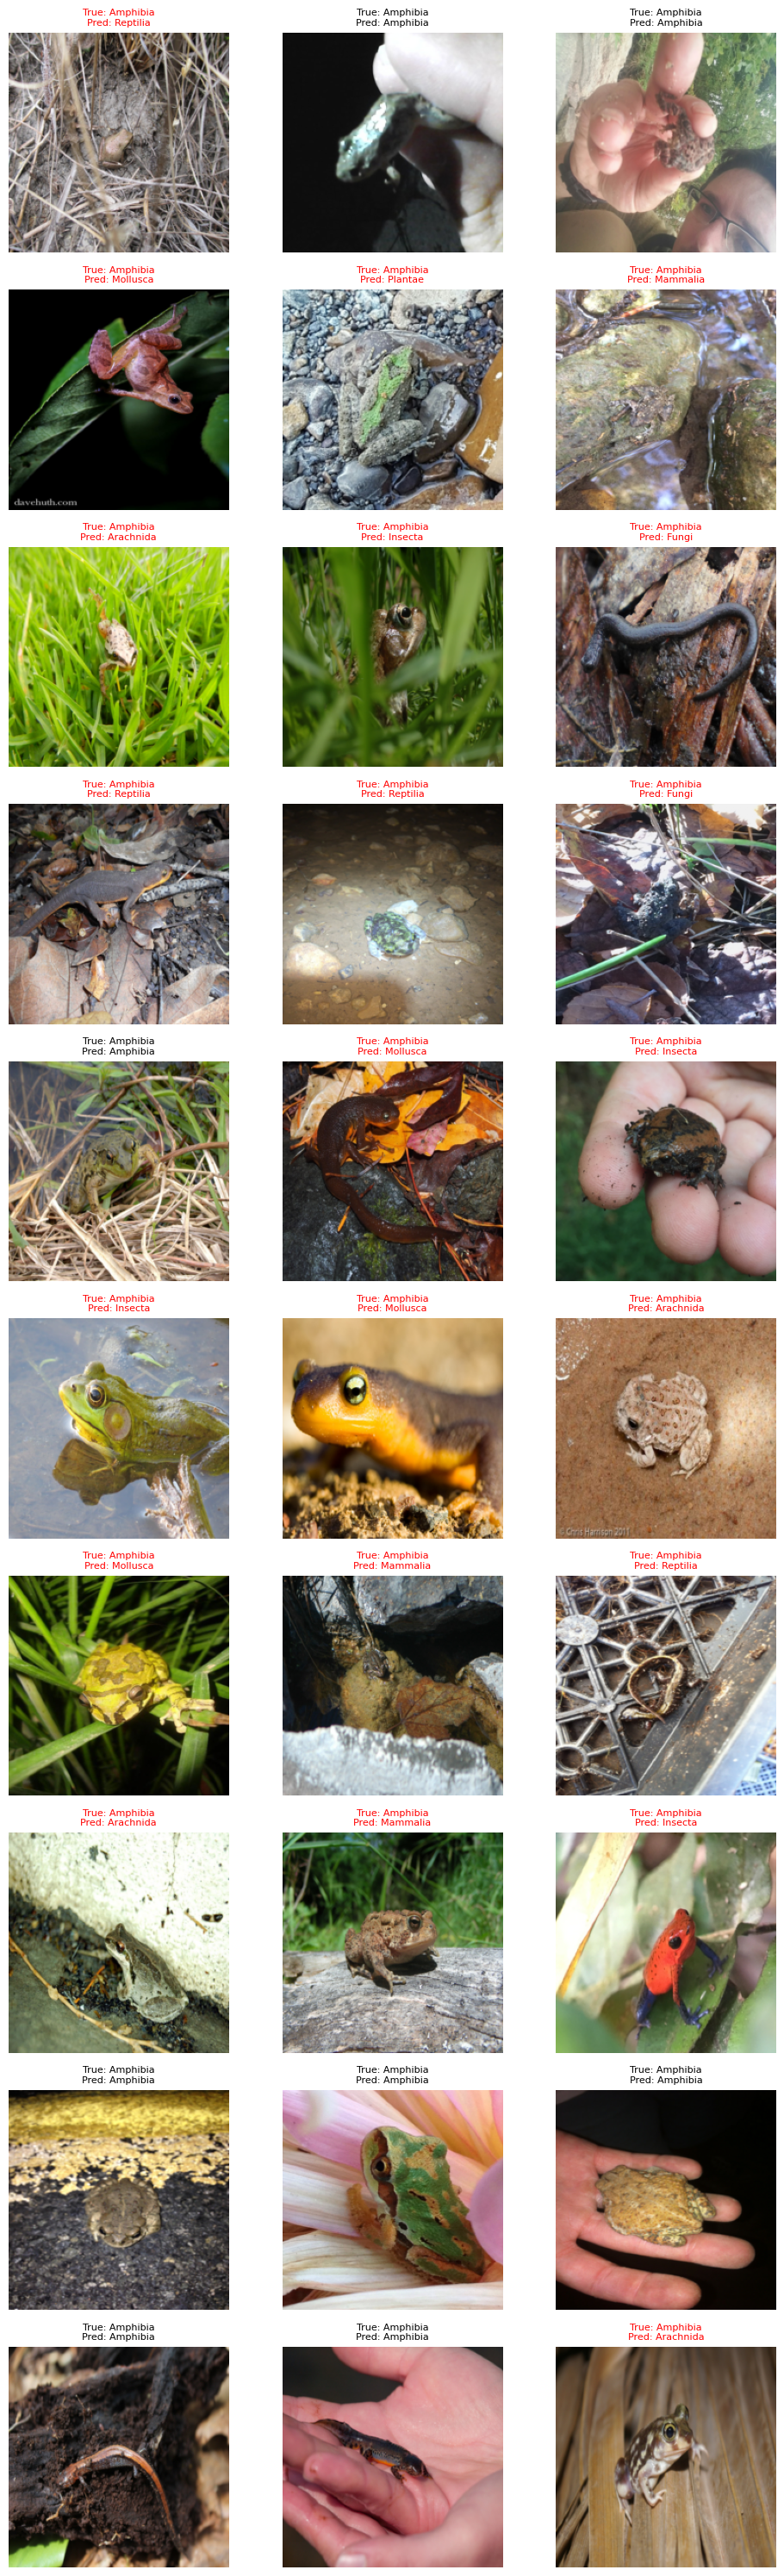

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
import torch

# Collect 30 test samples and their predictions
model.eval()
images_shown = 0
images_to_show = 30
images_list, preds_list, labels_list = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if images_shown >= images_to_show:
                break
            images_list.append(images[i].cpu())
            preds_list.append(predicted[i].cpu())
            labels_list.append(labels[i].cpu())
            images_shown += 1

        if images_shown >= images_to_show:
            break

# Denormalize images
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
images_list = [(img.permute(1, 2, 0) * std + mean).numpy() for img in images_list]

# Plot 10×3 grid with color-coded titles
fig, axes = plt.subplots(10, 3, figsize=(10, 30))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.clip(images_list[i], 0, 1))
    true_label = class_names[labels_list[i]]
    pred_label = class_names[preds_list[i]]

    title_color = "black" if true_label == pred_label else "red"
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8, color=title_color)
    ax.axis("off")

plt.tight_layout()

# Log to wandb
# wandb.log({"Test Predictions Grid": wandb.Image(fig)})
# Save the figure first
fig.savefig("test_predictions_grid.png")

# Then log it from file
wandb.log({"Test Predictions Grid": wandb.Image("test_predictions_grid.png")})



# Show the figure in notebook
plt.show()
plt.close(fig)
